In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
import os
import random
import sys
import transformers

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    BertTokenizer,
    BertForSequenceClassification,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    EvalPrediction,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import wandb
import copy
import torch.nn as nn
import math
from tqdm import tqdm, trange
from sklearn.metrics import f1_score
from transformers import EarlyStoppingCallback

# import loralib as lora
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    LoraConfig,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
    prepare_model_for_kbit_training,
)
from collections import Counter
import glob
import time
import datasets
import loralib as lora

/home/lab/bumjun/qlora/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore
    torch.use_deterministic_algorithms(True)


seed_everything(42)

In [3]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [4]:
def recon_error(original_weight, approx_weight):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.linalg.norm(original_weight.to(device) - approx_weight.to(device), "fro")

In [5]:
model_id = "microsoft/deberta-v2-xxlarge"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
config = LoraConfig(r=4, lora_alpha=8, target_modules=["query_proj", "value_proj"], task_type="SEQ_CLS")
model = get_peft_model(model, config)
print_trainable_parameters(model)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v2-xxlarge and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1182722 || all params: 1568096260 || trainable%: 0.075424068672927


In [6]:
model.base_model.model.deberta.encoder.layer[0].attention.self.query_proj.lora_A

ModuleDict(
  (default): Linear(in_features=1536, out_features=4, bias=False)
)

In [7]:
lora_A = model.base_model.model.deberta.encoder.layer[0].attention.self.query_proj.lora_A.default

In [8]:
lora_A = model.base_model.model.deberta.encoder.layer[0].attention.self.query_proj.lora_A.default.weight.transpose(0,1)
lora_A, lora_A.shape

(tensor([[-0.0037, -0.0002, -0.0136, -0.0114],
         [-0.0118, -0.0211, -0.0214,  0.0007],
         [-0.0003, -0.0050, -0.0224,  0.0027],
         ...,
         [-0.0077, -0.0008, -0.0219, -0.0033],
         [-0.0131, -0.0245, -0.0117,  0.0163],
         [-0.0070, -0.0254, -0.0136,  0.0109]], grad_fn=<TransposeBackward0>),
 torch.Size([1536, 4]))

In [10]:
lora_A_norm = torch.norm(lora_A)
lora_A_norm

tensor(1.1551, grad_fn=<LinalgVectorNormBackward0>)

In [ ]:
lora_B = model.base_model.model.deberta.encoder.layer[0].attention.self.query_proj.lora_B.default
lora_B.weight, lora_B.weight.shape, torch.norm(lora_B.weight)

(Parameter containing:
 tensor([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]], requires_grad=True),
 torch.Size([1536, 4]),
 tensor(0., grad_fn=<LinalgVectorNormBackward0>))

### query SVD

In [7]:
q_original_weight = model.deberta.encoder.layer[0].attention.self.query_proj.weight.data.T
q_original_weight, q_original_weight.shape, torch.norm(q_original_weight)

(tensor([[ 0.0712,  0.0211, -0.0921,  ..., -0.0111,  0.0479,  0.0247],
         [-0.0326,  0.0605, -0.1219,  ...,  0.0445, -0.0812, -0.0392],
         [ 0.0090,  0.0134,  0.0068,  ...,  0.0231, -0.0630,  0.0749],
         ...,
         [ 0.0343,  0.0161, -0.0853,  ..., -0.0633, -0.0336,  0.0295],
         [ 0.1448, -0.0611, -0.0674,  ..., -0.0059,  0.0809, -0.0400],
         [-0.0075,  0.0023, -0.0746,  ..., -0.0186, -0.0690, -0.0521]]),
 torch.Size([1536, 1536]),
 tensor(88.6837))

In [ ]:
q_proj_u, q_proj_s, q_proj_v = torch.linalg.svd(q_original_weight)
new_lora_A = q_proj_u[:, :4] @ torch.diag(q_proj_s[:4]).sqrt()
new_lora_A, new_lora_A.shape, torch.norm(new_lora_A)

(tensor([[ 0.2236, -0.0308,  0.0417,  0.0626],
         [ 0.1297, -0.1951,  0.0092,  0.0092],
         [ 0.0193,  0.0311, -0.0281, -0.0416],
         ...,
         [-0.0423,  0.0485, -0.1052, -0.0067],
         [ 0.0470, -0.0709, -0.0392,  0.0321],
         [-0.0780,  0.0835, -0.0392, -0.0022]]),
 torch.Size([1536, 4]),
 tensor(5.8884))

In [ ]:
q_reconstructed = q_proj_u @ torch.diag(q_proj_s) @ q_proj_v
recon_error(q_original_weight, q_reconstructed)

tensor(0.0002, device='cuda:0')

In [ ]:
q_reconstructed = q_proj_u[:, :4] @ torch.diag(q_proj_s[:4]) @ q_proj_v[:4, :]
recon_error(q_original_weight, q_reconstructed)

tensor(86.9137, device='cuda:0')

In [ ]:
q_proj_u[:, :4]

tensor([[ 0.0683, -0.0099,  0.0151,  0.0244],
        [ 0.0396, -0.0627,  0.0033,  0.0036],
        [ 0.0059,  0.0100, -0.0102, -0.0162],
        ...,
        [-0.0129,  0.0156, -0.0380, -0.0026],
        [ 0.0144, -0.0228, -0.0142,  0.0125],
        [-0.0238,  0.0268, -0.0142, -0.0009]])

In [ ]:
q_proj_u[:, :4].shape

torch.Size([1536, 4])

In [ ]:
q_proj_s[:4]

tensor([10.7285,  9.6862,  7.6498,  6.6093])

In [ ]:
torch.diag(q_proj_s[:4]), torch.diag(q_proj_s[:4]).shape

(tensor([[10.7285,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  9.6862,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  7.6498,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  6.6093]]),
 torch.Size([4, 4]))

In [ ]:
new_lora_A[:,0],new_lora_A[:,0].shape, torch.norm(new_lora_A[:,0])

(tensor([ 0.2236,  0.1297,  0.0193,  ..., -0.0423,  0.0470, -0.0780]),
 torch.Size([1536]),
 tensor(3.2754))

In [ ]:
lora_A[:, 0], lora_A[:, 0].shape, torch.norm(lora_A[:, 0])

(tensor([-0.0037, -0.0118, -0.0003,  ..., -0.0077, -0.0131, -0.0070],
        grad_fn=<SelectBackward0>),
 torch.Size([1536]),
 tensor(0.5674, grad_fn=<LinalgVectorNormBackward0>))

In [15]:
for i in range(4):
    lora_A = model.base_model.model.deberta.encoder.layer[0].attention.self.query_proj.lora_A.default.weight.T
    print(f"{i}th col",lora_A[:, i].shape, torch.norm(lora_A[:, i]))

0th col torch.Size([1536]) tensor(0.5674, grad_fn=<LinalgVectorNormBackward0>)
1th col torch.Size([1536]) tensor(0.5873, grad_fn=<LinalgVectorNormBackward0>)
2th col torch.Size([1536]) tensor(0.5792, grad_fn=<LinalgVectorNormBackward0>)
3th col torch.Size([1536]) tensor(0.5762, grad_fn=<LinalgVectorNormBackward0>)


In [8]:
for i in range(4):
    q_proj_u, q_proj_s, q_proj_v = torch.linalg.svd(q_original_weight)
    new_lora_A = q_proj_u[:, :4] @ torch.diag(q_proj_s[:4]).sqrt()
    print(f"{i}th col new_lora_A", new_lora_A[:, i].shape, torch.norm(new_lora_A[:, i]))

0th col new_lora_A torch.Size([1536]) tensor(3.2754)
1th col new_lora_A torch.Size([1536]) tensor(3.1123)
2th col new_lora_A torch.Size([1536]) tensor(2.7658)
3th col new_lora_A torch.Size([1536]) tensor(2.5709)


In [26]:
x = [0,1,2,3,4]
for i in range(5):
    new_x = 5+i
    x[i]= new_x
print(x)

[5, 6, 7, 8, 9]


In [ ]:
len_of_layers = len(model.deberta.encoder.layer)
q_new_lora_A_list = []
v_new_lora_A_list = []

q_new_lora_B_list = []
v_new_lora_B_list = []

approx_rank = 4
for layer_idx in range(len_of_layers):
    q_original_weight = model.deberta.encoder.layer[layer_idx].attention.self.query_proj.weight.data.T
    v_original_weight = model.deberta.encoder.layer[layer_idx].attention.self.value_proj.weight.data.T

    q_og_lora_A = model.base_model.model.deberta.encoder.layer[
        layer_idx
    ].attention.self.query_proj.lora_A.default.weight.T
    v_og_lora_A = model.base_model.model.deberta.encoder.layer[
        layer_idx
    ].attention.self.value_proj.lora_A.default.weight.T

    q_proj_u, q_proj_s, q_proj_v = torch.linalg.svd(q_original_weight)
    q_new_lora_A = q_proj_u[:, :approx_rank] @ torch.diag(q_proj_s[:approx_rank]).sqrt()
    q_new_lora_B = torch.diag(q_proj_s[:approx_rank]).sqrt() @ q_proj_v[:approx_rank, :]
    
    v_proj_u, v_proj_s, v_proj_v = torch.linalg.svd(v_original_weight)
    v_new_lora_A = v_proj_u[:, :approx_rank] @ torch.diag(v_proj_s[:approx_rank]).sqrt()
    v_new_lora_B = torch.diag(v_proj_s[:approx_rank]).sqrt() @ v_proj_v[:approx_rank, :]
    
    q_new_lora_B_list.append(q_new_lora_B)
    v_new_lora_B_list.append(v_new_lora_B)

    for i in range(4):
        print(f"Before Scale, q {i}th col Norm", torch.norm(q_new_lora_A[:, i]))

        q_og_lora_A_icol_norm = torch.norm(q_og_lora_A[:, i])
        q_new_lora_A_icol_norm = torch.norm(q_new_lora_A[:, i])

        q_scale = q_og_lora_A_icol_norm / q_new_lora_A_icol_norm

        q_new_lora_A[:, i] = q_new_lora_A[:, i] * q_scale

        print(f"After Scale, q {i}th col Norm", torch.norm(q_new_lora_A[:, i]))
        print("####################")

        print(f"Before Scale, v {i}th col Norm", torch.norm(v_new_lora_A[:, i]))

        v_og_lora_A_icol_norm = torch.norm(v_og_lora_A[:, i])
        v_new_lora_A_icol_norm = torch.norm(v_new_lora_A[:, i])

        v_scale = v_og_lora_A_icol_norm / v_new_lora_A_icol_norm

        v_new_lora_A[:, i] = v_new_lora_A[:, i] * v_scale

        print(f"After Scale, v {i}th col Norm", torch.norm(v_new_lora_A[:, i]))
        print("####################")

    q_new_lora_A_list.append(q_new_lora_A)
    v_new_lora_A_list.append(v_new_lora_A)

    model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.query_proj.lora_A.default.weight.data = (
        q_new_lora_A_list[layer_idx].transpose(0, 1).contiguous()
    )
    model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.value_proj.lora_A.default.weight.data = (
        v_new_lora_A_list[layer_idx].transpose(0, 1).contiguous()
    )
    
    model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.query_proj.lora_B.default.weight.data = (
        q_new_lora_B_list[layer_idx].transpose(0, 1).contiguous()
    )
    model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.value_proj.lora_B.default.weight.data = (
        v_new_lora_B_list[layer_idx].transpose(0, 1).contiguous()
    )

In [28]:
len_of_layers = len(model.deberta.encoder.layer)
q_new_lora_A_list = []
v_new_lora_A_list = []

for layer_idx in range(len_of_layers):
    q_original_weight = model.deberta.encoder.layer[layer_idx].attention.self.query_proj.weight.data.T
    v_original_weight = model.deberta.encoder.layer[layer_idx].attention.self.value_proj.weight.data.T

    q_og_lora_A = model.base_model.model.deberta.encoder.layer[
        layer_idx
    ].attention.self.query_proj.lora_A.default.weight.T
    v_og_lora_A = model.base_model.model.deberta.encoder.layer[
        layer_idx
    ].attention.self.value_proj.lora_A.default.weight.T

    q_proj_u, q_proj_s, q_proj_v = torch.linalg.svd(q_original_weight)
    q_new_lora_A = q_proj_u[:, :4] @ torch.diag(q_proj_s[:4]).sqrt()

    v_proj_u, v_proj_s, v_proj_v = torch.linalg.svd(v_original_weight)
    v_new_lora_A = v_proj_u[:, :4] @ torch.diag(v_proj_s[:4]).sqrt()

    for i in range(4):
        print(f"Before Scale, q {i}th col Norm", torch.norm(q_new_lora_A[:, i]))

        q_og_lora_A_icol_norm = torch.norm(q_og_lora_A[:, i])
        q_new_lora_A_icol_norm = torch.norm(q_new_lora_A[:, i])

        q_scale = q_og_lora_A_icol_norm / q_new_lora_A_icol_norm

        q_new_lora_A[:, i] = q_new_lora_A[:, i] * q_scale

        print(f"After Scale, q {i}th col Norm", torch.norm(q_new_lora_A[:, i]))
        print("####################")

        print(f"Before Scale, v {i}th col Norm", torch.norm(v_new_lora_A[:, i]))

        v_og_lora_A_icol_norm = torch.norm(v_og_lora_A[:, i])
        v_new_lora_A_icol_norm = torch.norm(v_new_lora_A[:, i])

        v_scale = v_og_lora_A_icol_norm / v_new_lora_A_icol_norm

        v_new_lora_A[:, i] = v_new_lora_A[:, i] * v_scale

        print(f"After Scale, v {i}th col Norm", torch.norm(v_new_lora_A[:, i]))
        print("####################")

    q_new_lora_A_list.append(q_new_lora_A)
    v_new_lora_A_list.append(v_new_lora_A)

    model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.query_proj.lora_A.default.weight.data = (
        q_new_lora_A_list[layer_idx].transpose(0, 1).contiguous()
    )
    model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.value_proj.lora_A.default.weight.data = (
        v_new_lora_A_list[layer_idx].transpose(0, 1).contiguous()
    )

Before Scale, q 0th col Norm tensor(3.2754)
After Scale, q 0th col Norm tensor(0.5823, grad_fn=<LinalgVectorNormBackward0>)
####################
Before Scale, v 0th col Norm tensor(2.0830)
After Scale, v 0th col Norm tensor(0.5780, grad_fn=<LinalgVectorNormBackward0>)
####################
Before Scale, q 1th col Norm tensor(3.1123, grad_fn=<LinalgVectorNormBackward0>)
After Scale, q 1th col Norm tensor(0.5741, grad_fn=<LinalgVectorNormBackward0>)
####################
Before Scale, v 1th col Norm tensor(1.9221, grad_fn=<LinalgVectorNormBackward0>)
After Scale, v 1th col Norm tensor(0.5697, grad_fn=<LinalgVectorNormBackward0>)
####################
Before Scale, q 2th col Norm tensor(2.7658, grad_fn=<LinalgVectorNormBackward0>)
After Scale, q 2th col Norm tensor(0.5851, grad_fn=<LinalgVectorNormBackward0>)
####################
Before Scale, v 2th col Norm tensor(1.9160, grad_fn=<LinalgVectorNormBackward0>)
After Scale, v 2th col Norm tensor(0.5672, grad_fn=<LinalgVectorNormBackward0>)
###

    Layer  lora_A Norm  new_lora_A Norm
0       0     0.567429         3.275432
1       1     0.585682         2.727432
2       2     0.579598         2.940313
3       3     0.576057         3.074098
4       4     0.575257         2.891766
5       5     0.579585         3.040698
6       6     0.578364         2.906408
7       7     0.573760         3.160725
8       8     0.573446         3.096008
9       9     0.565393         3.062362
10     10     0.582618         3.013615
11     11     0.569206         2.994594
12     12     0.568341         3.047105
13     13     0.581365         2.691216
14     14     0.566967         3.072535
15     15     0.581771         3.119625
16     16     0.574085         2.983188
17     17     0.574927         3.053514
18     18     0.575363         2.897182
19     19     0.586855         3.152239
20     20     0.578613         3.093604
21     21     0.570879         3.077572
22     22     0.577624         3.049182
23     23     0.573886         2.944951


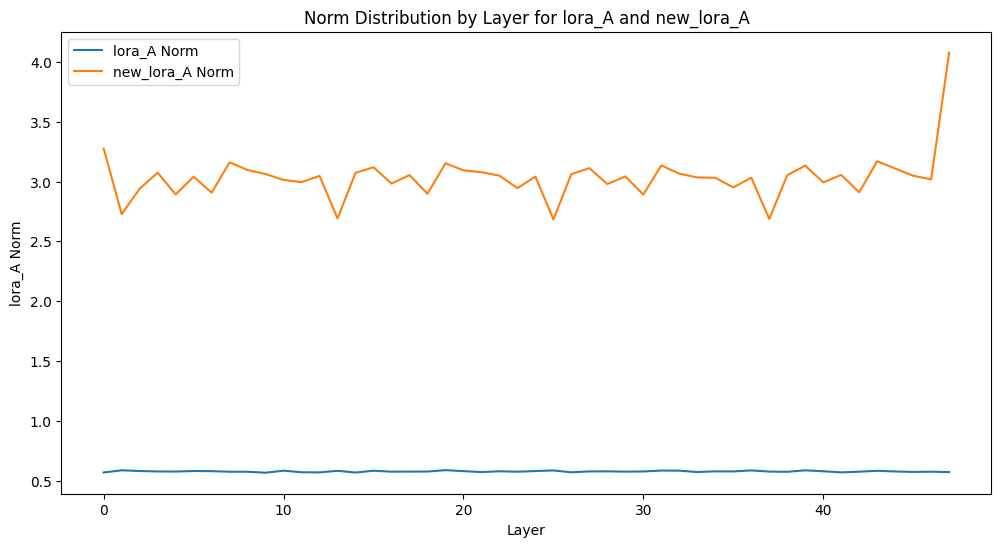

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DataFrame을 구성할 데이터를 저장할 리스트
data = []

for i in range(48):
    lora_A = model.base_model.model.deberta.encoder.layer[i].attention.self.query_proj.lora_A.default.weight.T
    lora_A_norm = torch.norm(lora_A[:, 0]).item()
    q_original_weight = model.deberta.encoder.layer[i].attention.self.query_proj.weight.data.T
    q_proj_u, q_proj_s, q_proj_v = torch.linalg.svd(q_original_weight)
    new_lora_A = q_proj_u[:, :4] @ torch.diag(q_proj_s[:4]).sqrt()
    new_lora_A_norm = torch.norm(new_lora_A[:, 0]).item()
    # 각 layer의 lora_A 및 new_lora_A의 norm 값을 데이터에 추가
    data.append({"Layer": i, "lora_A Norm": lora_A_norm, "new_lora_A Norm": new_lora_A_norm})

# 리스트를 DataFrame으로 변환
df = pd.DataFrame(data)

# DataFrame을 출력
print(df)

# Layer에 따른 lora_A Norm과 new_lora_A Norm의 분포를 표시하는 lineplot 생성
plt.figure(figsize=(12, 6))
sns.lineplot(x="Layer", y="lora_A Norm", data=df, label="lora_A Norm")
sns.lineplot(x="Layer", y="new_lora_A Norm", data=df, label="new_lora_A Norm")
plt.title("Norm Distribution by Layer for lora_A and new_lora_A")
plt.legend()
plt.show()

In [ ]:
lora_A_norms = []
new_lora_A_norms = []
for i in range(48):
    lora_A = model.base_model.model.deberta.encoder.layer[i].attention.self.query_proj.lora_A.default.weight.T
    lora_A_norms.append(torch.norm(lora_A[:, 0]))

    q_original_weight = model.deberta.encoder.layer[i].attention.self.query_proj.weight.data.T
    q_proj_u, q_proj_s, q_proj_v = torch.linalg.svd(q_original_weight)
    new_lora_A = q_proj_u[:, :4] @ torch.diag(q_proj_s[:4]).sqrt()
    new_lora_A_norms.append(torch.norm(new_lora_A[:, 0]))

lora_A_norms, new_lora_A_norms

([tensor(0.5674, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5857, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5796, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5761, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5753, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5796, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5784, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5738, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5734, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5654, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5826, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5692, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5683, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5814, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5670, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5818, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5741, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0.5749, grad_fn=<LinalgVectorNormBackward0>),
  tensor(0

In [ ]:
new_lora_A_norms[0]

tensor(3.2754)

In [ ]:
for i in range(48):
    scale = lora_A_norms[i] / new_lora_A_norms[i]
    scaled_lora = model.base_model.model.deberta.encoder.layer[i].attention.self.query_proj.lora_A.default.weight.T * scale
    scaled_norm = torch.norm(scaled_lora[:, 0])

## Head-Wise Scale

0번째 Weight의 Head-Wise

In [6]:
q_loraA_head_list = []
v_loraA_head_list = []
q_weight = model.base_model.model.deberta.encoder.layer[0].attention.self.query_proj.weight.T
v_weight = model.base_model.model.deberta.encoder.layer[0].attention.self.value_proj.weight.T
all_q_head = copy.deepcopy(q_weight)
all_q_head = all_q_head.reshape(24, 1536, 64)
all_v_head = copy.deepcopy(v_weight)
all_v_head = all_v_head.reshape(24, 1536, 64)
all_q_head.shape, all_v_head.shape

(torch.Size([24, 1536, 64]), torch.Size([24, 1536, 64]))

In [8]:
model.base_model.model.deberta.encoder.layer[0].attention.self.query_proj.weight.T

tensor([[ 0.0712,  0.0211, -0.0921,  ..., -0.0111,  0.0479,  0.0247],
        [-0.0326,  0.0605, -0.1219,  ...,  0.0445, -0.0812, -0.0392],
        [ 0.0090,  0.0134,  0.0068,  ...,  0.0231, -0.0630,  0.0749],
        ...,
        [ 0.0343,  0.0161, -0.0853,  ..., -0.0633, -0.0336,  0.0295],
        [ 0.1448, -0.0611, -0.0674,  ..., -0.0059,  0.0809, -0.0400],
        [-0.0075,  0.0023, -0.0746,  ..., -0.0186, -0.0690, -0.0521]])

In [11]:
norm_list = []
for i in range(24):
    norm_of_head = torch.norm(all_q_head[i])
    norm_list.append(norm_of_head)
    print(f"{i}th head norm", norm_of_head)

0th head norm tensor(18.0516)
1th head norm tensor(18.1587)
2th head norm tensor(17.7440)
3th head norm tensor(19.0205)
4th head norm tensor(18.2110)
5th head norm tensor(18.1781)
6th head norm tensor(18.0326)
7th head norm tensor(17.7316)
8th head norm tensor(17.9980)
9th head norm tensor(17.7017)
10th head norm tensor(17.9464)
11th head norm tensor(18.2455)
12th head norm tensor(18.5894)
13th head norm tensor(18.3362)
14th head norm tensor(17.9002)
15th head norm tensor(18.0703)
16th head norm tensor(18.5292)
17th head norm tensor(17.9256)
18th head norm tensor(18.5164)
19th head norm tensor(18.2631)
20th head norm tensor(17.7721)
21th head norm tensor(17.8273)
22th head norm tensor(17.8645)
23th head norm tensor(17.7883)


In [14]:
all_q_head[0], torch.norm(all_q_head[0])

(tensor([[ 0.0712,  0.0211, -0.0921,  ..., -0.0527,  0.0543,  0.0396],
         [-0.0436,  0.0284,  0.0367,  ...,  0.0268,  0.0274, -0.0667],
         [-0.0261, -0.0560,  0.0159,  ...,  0.0166,  0.0348, -0.0400],
         ...,
         [-0.0388, -0.0961,  0.1036,  ...,  0.1256,  0.0967, -0.0703],
         [-0.0631,  0.0809, -0.0771,  ...,  0.0237, -0.0681,  0.0747],
         [ 0.0491,  0.1465, -0.0120,  ...,  0.1124,  0.0781, -0.0861]]),
 tensor(18.0516))

In [28]:
q_head = all_q_head[0]
q_u, q_s, q_vt = torch.linalg.svd(q_head)
q_u.shape, q_s.shape, q_vt.shape

(torch.Size([1536, 1536]), torch.Size([64]), torch.Size([64, 64]))

In [29]:
torch.diag(q_s)

tensor([[3.3308, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 2.7497, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.7257,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.7899, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.7736, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.7647]])

In [30]:
torch.diag(q_s).sqrt()

tensor([[1.8251, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.6582, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.6510,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.3379, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.3318, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.3284]])

In [31]:
q_u[:, :1]

tensor([[-0.0153],
        [ 0.0038],
        [-0.0069],
        ...,
        [ 0.0242],
        [ 0.0127],
        [-0.0069]])

In [20]:
q_loraA_head = q_u[:, :1] @ torch.diag(q_s[:1])
q_loraA_head.shape, torch.norm(q_loraA_head)

(torch.Size([1536, 1]), tensor(3.3308))

In [34]:
for i in range(24):
    q_head = all_q_head[i]
    q_u, q_s, q_vt = torch.linalg.svd(q_head)
    q_loraA_head = q_u[:, :1] @ torch.diag(q_s[:1])
    print(f"{i}th head norm", torch.norm(q_loraA_head))

0th head norm tensor(3.3308)
1th head norm tensor(2.8173)
2th head norm tensor(2.6986)
3th head norm tensor(3.2101)
4th head norm tensor(2.8012)
5th head norm tensor(2.7725)
6th head norm tensor(2.8254)
7th head norm tensor(2.6568)
8th head norm tensor(2.7803)
9th head norm tensor(2.6874)
10th head norm tensor(2.7354)
11th head norm tensor(2.7827)
12th head norm tensor(3.5680)
13th head norm tensor(2.7754)
14th head norm tensor(2.7380)
15th head norm tensor(2.7538)
16th head norm tensor(2.9089)
17th head norm tensor(2.7351)
18th head norm tensor(2.9385)
19th head norm tensor(2.7841)
20th head norm tensor(2.6948)
21th head norm tensor(2.7090)
22th head norm tensor(2.6923)
23th head norm tensor(2.7195)


In [35]:
for i in range(48):
    q_loraA_head_list = []
    v_loraA_head_list = []
    q_weight = model.base_model.model.deberta.encoder.layer[i].attention.self.query_proj.weight.T
    v_weight = model.base_model.model.deberta.encoder.layer[i].attention.self.value_proj.weight.T
    all_q_head = copy.deepcopy(q_weight)
    all_q_head = all_q_head.reshape(24, 1536, 64)
    all_v_head = copy.deepcopy(v_weight)
    all_v_head = all_v_head.reshape(24, 1536, 64)
    print(f"#####{i}th layer#####")
    for j in range(24):
        q_head = all_q_head[j]
        q_u, q_s, q_vt = torch.linalg.svd(q_head)
        q_loraA_head = q_u[:, :1] @ torch.diag(q_s[:1])
        print(f"{i}th Layer {j}th head norm", torch.norm(q_loraA_head))

#####0th layer#####
0th Layer 0th head norm tensor(3.3308)
0th Layer 1th head norm tensor(2.8173)
0th Layer 2th head norm tensor(2.6986)
0th Layer 3th head norm tensor(3.2101)
0th Layer 4th head norm tensor(2.8012)
0th Layer 5th head norm tensor(2.7725)
0th Layer 6th head norm tensor(2.8254)
0th Layer 7th head norm tensor(2.6568)
0th Layer 8th head norm tensor(2.7803)
0th Layer 9th head norm tensor(2.6874)
0th Layer 10th head norm tensor(2.7354)
0th Layer 11th head norm tensor(2.7827)
0th Layer 12th head norm tensor(3.5680)
0th Layer 13th head norm tensor(2.7754)
0th Layer 14th head norm tensor(2.7380)
0th Layer 15th head norm tensor(2.7538)
0th Layer 16th head norm tensor(2.9089)
0th Layer 17th head norm tensor(2.7351)
0th Layer 18th head norm tensor(2.9385)
0th Layer 19th head norm tensor(2.7841)
0th Layer 20th head norm tensor(2.6948)
0th Layer 21th head norm tensor(2.7090)
0th Layer 22th head norm tensor(2.6923)
0th Layer 23th head norm tensor(2.7195)
#####1th layer#####
1th Layer 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

head_data = []

for i in range(48):
    q_loraA_head_list = []
    v_loraA_head_list = []
    q_weight = model.base_model.model.deberta.encoder.layer[i].attention.self.query_proj.weight.T
    v_weight = model.base_model.model.deberta.encoder.layer[i].attention.self.value_proj.weight.T
    all_q_head = copy.deepcopy(q_weight)
    all_q_head = all_q_head.reshape(24, 1536, 64)
    all_v_head = copy.deepcopy(v_weight)
    all_v_head = all_v_head.reshape(24, 1536, 64)
    for j in range(24):
        q_head = all_q_head[j]
        q_u, q_s, q_vt = torch.linalg.svd(q_head)
        q_loraA_head = q_u[:, :1] @ torch.diag(q_s[:1])
        norm = torch.norm(q_loraA_head).item()
        # 각 layer 및 head의 norm 값을 데이터에 추가
        head_data.append({"Layer": i, "Head": j, "Norm": norm})

df = pd.DataFrame(head_data)
print(df)

plt.figure(figsize=(12, 6))
sns.boxplot(x="Layer", y="Norm", data=df)
plt.title("Norm Distribution by Layer and Head")
plt.show()

In [ ]:
df.describe()

In [ ]:
def deberta_init_dW_A_with_svd_us_by_head_scalng(model, approx_rank):
    len_of_layers = len(model.base_model.model.deberta.encoder.layer)
    for layer_idx in range(len_of_layers):
        print(f"{layer_idx}th Layer ")
        q_loraA_head_list = []
        v_loraA_head_list = []

        q_weight = model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.query_proj.weight.T
        v_weight = model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.value_proj.weight.T

        q_og_lora_A = model.base_model.model.deberta.encoder.layer[
            layer_idx
        ].attention.self.query_proj.lora_A.default.weight.T
        v_og_lora_A = model.base_model.model.deberta.encoder.layer[
            layer_idx
        ].attention.self.value_proj.lora_A.default.weight.T

        all_q_head = copy.deepcopy(q_weight)
        all_q_head = all_q_head.reshape(approx_rank, 1536, 1536 // approx_rank)

        all_v_head = copy.deepcopy(v_weight)
        all_v_head = all_v_head.reshape(approx_rank, 1536, 1536 // approx_rank)

        for j in range(approx_rank):
            q_head = all_q_head[j]
            q_u, q_s, q_vt = torch.linalg.svd(q_head)
            q_loraA_head = q_u[:, :1] @ torch.diag(q_s[:1])

            v_head = all_v_head[j]
            v_u, v_s, v_vt = torch.linalg.svd(v_head)
            v_loraA_head = v_u[:, :1] @ torch.diag(v_s[:1])
            print("-" * 50)
            print(
                f"{j}th head norm Before Scaling \n q_loraA_head : {torch.norm(q_loraA_head)} v_loraA_head : {torch.norm(v_loraA_head)}"
            )
            q_og_lora_A_icol_norm = torch.norm(q_og_lora_A[:, 1])
            q_new_lora_A_icol_norm = torch.norm(q_new_lora_A[:, 1])
            v_og_lora_A_icol_norm = torch.norm(v_og_lora_A[:, 1])
            v_new_lora_A_icol_norm = torch.norm(v_new_lora_A[:, 1])

            q_scale = q_og_lora_A_icol_norm / q_new_lora_A_icol_norm
            v_scale = v_og_lora_A_icol_norm / v_new_lora_A_icol_norm

            q_loraA_head = q_loraA_head * q_scale
            v_loraA_head = v_loraA_head * v_scale

            print(
                f"{j}th head norm After Scaling \n q_loraA_head : {torch.norm(q_loraA_head)} v_loraA_head : {torch.norm(v_loraA_head)}"
            )
            print("-" * 50)
            q_loraA_head_list.append(q_loraA_head)
            v_loraA_head_list.append(v_loraA_head)

        q_loraA = torch.cat(q_loraA_head_list, dim=1)
        v_loraA = torch.cat(v_loraA_head_list, dim=1)

        model.base_model.model.deberta.encoder.layer[
            layer_idx
        ].attention.self.query_proj.lora_A.default.weight.data = q_loraA.T.contiguous()
        model.base_model.model.deberta.encoder.layer[
            layer_idx
        ].attention.self.value_proj.lora_A.default.weight.data = v_loraA.T.contiguous()

        model.base_model.model.deberta.encoder.layer[
            layer_idx
        ].attention.self.query_proj.lora_B.default.weight.data = torch.zeros_like(
            model.base_model.model.deberta.encoder.layer[
                layer_idx
            ].attention.self.query_proj.lora_B.default.weight.data
        )
        model.base_model.model.deberta.encoder.layer[
            layer_idx
        ].attention.self.value_proj.lora_B.default.weight.data = torch.zeros_like(
            model.base_model.model.deberta.encoder.layer[
                layer_idx
            ].attention.self.value_proj.lora_B.default.weight.data
        )

        print(f"Complete init LoraA! layer: {layer_idx}, q_loraA: {model.base_model.model.deberta.encoder.layer[
            layer_idx
        ].attention.self.query_proj.lora_A.default.weight.shape}, v_loraA: {model.base_model.model.deberta.encoder.layer[
            layer_idx
        ].attention.self.value_proj.lora_A.default.weight.shape}")

In [39]:
approx_rank = 24

In [55]:
model_id = "microsoft/deberta-v2-xxlarge"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
config = LoraConfig(r=24, lora_alpha=24, target_modules=["query_proj", "value_proj"], task_type="SEQ_CLS")
model = get_peft_model(model, config)
print_trainable_parameters(model)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v2-xxlarge and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 7080962 || all params: 1573994500 || trainable%: 0.4498720929456869


In [48]:
tmp_w = model.base_model.model.deberta.encoder.layer[0].attention.self.query_proj.lora_A.default.weight.T
tmp_w.shape

torch.Size([1536, 24])

In [50]:
torch.norm(tmp_w)

tensor(2.8253, grad_fn=<LinalgVectorNormBackward0>)

In [57]:
tmp_w[:, 0].shape

torch.Size([1536])

In [65]:
tmp_w[:, 0]

tensor([ 0.0199, -0.0079, -0.0229,  ...,  0.0175,  0.0226,  0.0201],
       grad_fn=<SelectBackward0>)

In [64]:
tmp_w[:, 0 : 0 + 1]

tensor([[ 0.0199],
        [-0.0079],
        [-0.0229],
        ...,
        [ 0.0175],
        [ 0.0226],
        [ 0.0201]], grad_fn=<SliceBackward0>)

In [59]:
for i in range(24):
    print(torch.norm(tmp_w[:, i:i+1]))

tensor(0.5786, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5835, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5679, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5776, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5689, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5709, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5822, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5736, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5832, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5787, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5741, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5794, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5715, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5742, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5777, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5629, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5905, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5812, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5836, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.580

In [53]:
len_of_layers = len(model.base_model.model.deberta.encoder.layer)
for i in range(len_of_layers):
    q_loraA_head_list = []
    v_loraA_head_list = []
    q_weight = model.base_model.model.deberta.encoder.layer[i].attention.self.query_proj.weight.T
    v_weight = model.base_model.model.deberta.encoder.layer[i].attention.self.value_proj.weight.T
    all_q_head = copy.deepcopy(q_weight)
    all_q_head = all_q_head.reshape(approx_rank, 1536, 1536 // approx_rank)
    all_v_head = copy.deepcopy(v_weight)
    all_v_head = all_v_head.reshape(approx_rank, 1536, 1536 // approx_rank)
    for j in range(approx_rank):
        q_head = all_q_head[j]
        q_u, q_s, q_vt = torch.linalg.svd(q_head)
        q_loraA_head = q_u[:, :1] @ torch.diag(q_s[:1])
        v_head = all_v_head[j]
        v_u, v_s, v_vt = torch.linalg.svd(v_head)
        v_loraA_head = v_u[:, :1] @ torch.diag(v_s[:1])
        q_loraA_head_list.append(q_loraA_head)
        v_loraA_head_list.append(v_loraA_head)
    print(
        f"Complete Merge Head! len of q_loraA_head_list: {len(q_loraA_head_list)},len of v_loraA_head_list: {len(v_loraA_head_list)}"
    )
    q_loraA = torch.cat(q_loraA_head_list, dim=1)
    v_loraA = torch.cat(v_loraA_head_list, dim=1)
    model.base_model.model.deberta.encoder.layer[
        i
    ].attention.self.query_proj.lora_A.default.weight.data = q_loraA.T.contiguous()
    model.base_model.model.deberta.encoder.layer[
        i
    ].attention.self.value_proj.lora_A.default.weight.data = v_loraA.T.contiguous()
    model.base_model.model.deberta.encoder.layer[
        i
    ].attention.self.query_proj.lora_B.default.weight.data = torch.zeros_like(
        model.base_model.model.deberta.encoder.layer[i].attention.self.query_proj.lora_B.default.weight.data
    )
    model.base_model.model.deberta.encoder.layer[
        i
    ].attention.self.value_proj.lora_B.default.weight.data = torch.zeros_like(
        model.base_model.model.deberta.encoder.layer[i].attention.self.value_proj.lora_B.default.weight.data
    )
    print(f"Complete! Norm of q_loraA: {torch.norm(q_loraA)}, Norm of v_loraA: {torch.norm(v_loraA)}")
    #print(f"Complete init LoraA! layer: {i}, q_loraA: {q_loraA.shape}, v_loraA: {v_loraA.shape}")

Complete Merge Head! len of q_loraA_head_list: 24,len of v_loraA_head_list: 24
Complete! Norm of q_loraA: 13.944880485534668, Norm of v_loraA: 7.784212112426758
Complete Merge Head! len of q_loraA_head_list: 24,len of v_loraA_head_list: 24
Complete! Norm of q_loraA: 8.423471450805664, Norm of v_loraA: 6.587897777557373
Complete Merge Head! len of q_loraA_head_list: 24,len of v_loraA_head_list: 24
Complete! Norm of q_loraA: 8.42933177947998, Norm of v_loraA: 7.465761661529541
Complete Merge Head! len of q_loraA_head_list: 24,len of v_loraA_head_list: 24
Complete! Norm of q_loraA: 8.418700218200684, Norm of v_loraA: 7.929988384246826
Complete Merge Head! len of q_loraA_head_list: 24,len of v_loraA_head_list: 24
Complete! Norm of q_loraA: 8.643241882324219, Norm of v_loraA: 7.301017761230469


KeyboardInterrupt: 

In [66]:
len_of_layers = len(model.base_model.model.deberta.encoder.layer)
for layer_idx in range(len_of_layers):
    print(f"{layer_idx}th Layer ")
    q_loraA_head_list = []
    v_loraA_head_list = []
    q_weight = model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.query_proj.weight.T
    v_weight = model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.value_proj.weight.T

    q_og_lora_A = model.base_model.model.deberta.encoder.layer[
        layer_idx
    ].attention.self.query_proj.lora_A.default.weight.T
    v_og_lora_A = model.base_model.model.deberta.encoder.layer[
        layer_idx
    ].attention.self.value_proj.lora_A.default.weight.T

    all_q_head = copy.deepcopy(q_weight)
    all_q_head = all_q_head.reshape(approx_rank, 1536, 1536 // approx_rank)
    all_v_head = copy.deepcopy(v_weight)
    all_v_head = all_v_head.reshape(approx_rank, 1536, 1536 // approx_rank)

    for j in range(approx_rank):
        q_head = all_q_head[j]
        q_u, q_s, q_vt = torch.linalg.svd(q_head)
        q_loraA_head = q_u[:, :1] @ torch.diag(q_s[:1])
        v_head = all_v_head[j]
        v_u, v_s, v_vt = torch.linalg.svd(v_head)
        v_loraA_head = v_u[:, :1] @ torch.diag(v_s[:1])
        print("-" * 50)
        print(
            f"{j}th head norm Before Scaling \n q_loraA_head : {torch.norm(q_loraA_head)} v_loraA_head : {torch.norm(v_loraA_head)}"
        )
        q_og_lora_A_icol_norm = torch.norm(q_og_lora_A[:, j : j + 1])
        v_og_lora_A_icol_norm = torch.norm(v_og_lora_A[:, j : j + 1])

        q_scale = q_og_lora_A_icol_norm / torch.norm(q_loraA_head)
        v_scale = v_og_lora_A_icol_norm / torch.norm(v_loraA_head)

        q_loraA_head = q_loraA_head * q_scale
        v_loraA_head = v_loraA_head * v_scale
        print(
            f"{j}th head norm After Scaling \n q_loraA_head : {torch.norm(q_loraA_head)} v_loraA_head : {torch.norm(v_loraA_head)}"
        )
        print("-" * 50)
        q_loraA_head_list.append(q_loraA_head)
        v_loraA_head_list.append(v_loraA_head)
    q_loraA = torch.cat(q_loraA_head_list, dim=1)
    v_loraA = torch.cat(v_loraA_head_list, dim=1)
    model.base_model.model.deberta.encoder.layer[
        layer_idx
    ].attention.self.query_proj.lora_A.default.weight.data = q_loraA.T.contiguous()
    model.base_model.model.deberta.encoder.layer[
        layer_idx
    ].attention.self.value_proj.lora_A.default.weight.data = v_loraA.T.contiguous()
    model.base_model.model.deberta.encoder.layer[
        layer_idx
    ].attention.self.query_proj.lora_B.default.weight.data = torch.zeros_like(
        model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.query_proj.lora_B.default.weight.data
    )
    model.base_model.model.deberta.encoder.layer[
        layer_idx
    ].attention.self.value_proj.lora_B.default.weight.data = torch.zeros_like(
        model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.value_proj.lora_B.default.weight.data
    )
    print(
        f"Complete init LoraA! layer: {layer_idx}, q_loraA: {torch.norm(model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.query_proj.lora_A.default.weight)}, v_loraA: {torch.norm(model.base_model.model.deberta.encoder.layer[layer_idx].attention.self.value_proj.lora_A.default.weight)}"
    )

0th Layer 
--------------------------------------------------
0th head norm Before Scaling 
 q_loraA_head : 3.3308427333831787 v_loraA_head : 1.5449029207229614
0th head norm After Scaling 
 q_loraA_head : 0.5812019109725952 v_loraA_head : 0.5815222263336182
--------------------------------------------------
--------------------------------------------------
1th head norm Before Scaling 
 q_loraA_head : 2.817272663116455 v_loraA_head : 1.5823298692703247
1th head norm After Scaling 
 q_loraA_head : 0.5801612138748169 v_loraA_head : 0.5802536010742188
--------------------------------------------------
--------------------------------------------------
2th head norm Before Scaling 
 q_loraA_head : 2.6986498832702637 v_loraA_head : 1.5997166633605957
2th head norm After Scaling 
 q_loraA_head : 0.5838015079498291 v_loraA_head : 0.5741603970527649
--------------------------------------------------
--------------------------------------------------
3th head norm Before Scaling 
 q_loraA_hea

KeyboardInterrupt: 

In [43]:
torch.norm(model.base_model.model.deberta.encoder.layer[0].attention.self.query_proj.lora_A.default.weight)

tensor(2.8770, grad_fn=<LinalgVectorNormBackward0>)

In [44]:
model.base_model.model.deberta.encoder.layer[0].attention.self.query_proj.lora_A.default

Linear(in_features=1536, out_features=4, bias=False)